In [2]:
import sys
sys.path.append('C:\Program Files\Anaconda3\Lib\site-packages')

In [3]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

C:\Program Files\Anaconda3\Lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
Slow version of gensim.models.doc2vec is being used


## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейки нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [4]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(text, stopwords):
    words = re.findall(r'[a-zа-яё]+', text.lower())
    clean = [morph.parse(word)[0].normal_form for word in words if word not in stopwords]
    return clean

## Возьмем теже данные

In [ ]:
# habr_texts = [clean(word_tokenize(remove_tags(text.lower()))) for text in open('habr_texts.txt')]

Загрузим уже нормализованные данные для моделей gensim

In [5]:
habr_texts = open('habr_text_clean.txt', encoding = 'utf-8').read().splitlines()

In [6]:
habr_texts = [text.split() for text in habr_texts]

In [17]:
# вернемся сюда через какое-то время
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
                           common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                          # не будут учитываться
p = gensim.models.phrases.Phraser(ph)


C:\Program Files\Anaconda3\Lib\site-packages\gensim\models\phrases.py:275: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):


In [20]:
ngrammed_habr_texts = [p[habr_text] for habr_text in habr_texts]

In [55]:
f = open('habr_texts.vw', 'w', encoding = 'utf-8')

for i, text in enumerate(ngrammed_habr_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()



Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [9]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [56]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [7]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [57]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [58]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [59]:
dictionary.save_text(dictionary_path = 'dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

In [8]:
dictionary = artm.Dictionary()
dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [60]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [61]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [62]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [63]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 1600.059 (ARTM)


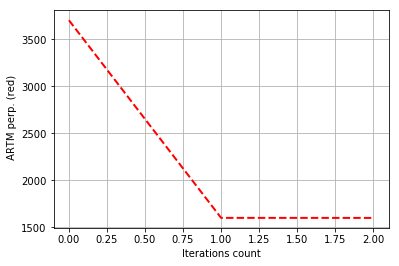

In [64]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [65]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [66]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [67]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.800 ARTM)
Sparsity Theta: 0.141 (ARTM)
Kernel contrast: 0.288 (ARTM)
Kernel purity: 0.204 (ARTM)
Perplexity: 1087.461 (ARTM)


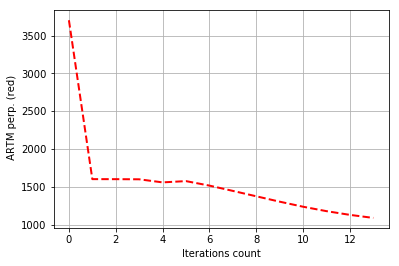

In [68]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

In [69]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
machine_learning
проблема
конец_ноябрь
deep_learning
кат
жаловаться
онлайн_трансляция
самый
место_проведение
митапа
---------
topic_1: 
ноутбук
компьютер
оперативный_память
устройство
intel
жёсткий_диск
память
процессор
процессор_intel
рубль
---------
topic_2: 
курс
лекция
человек
станок
деталь
хороший
слово
бумага
дело
модель
---------
topic_3: 
система
результат
являться
процесс
решение
проблема
оценка
регион
большой
анализ
---------
topic_4: 
процессор
инструкция
архитектура
ассемблер
программа
результат
память
компьютер
процесс
иметь
---------
topic_5: 
являться
вид
процесс
должный
простой
позволять
пример
разный
некоторый
наш
---------
topic_6: 
пользователь
использование
необходимый
должный
случай
система
использоваться
любой
ваш
создание
---------
topic_7: 
заказчик
задача
резервный_копия
диск
проект
исполнитель
нагрузка
копия
сервер
случай
---------
topic_8: 
конференция
тема
мастер_класс
участник
писать
проблема
ссылка
рассказать
клиент
наш
---------
topic_9: 
програ

Попробуем изменить количество тем

In [10]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(100)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 100)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 100)])
                                    ]
                        )



In [11]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [12]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

In [13]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 1575.435 (ARTM)


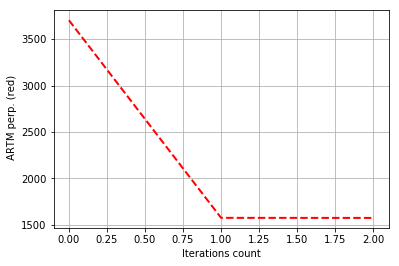

In [14]:
print_measures(model_artm)

In [15]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 100)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 100)]))

In [16]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [17]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.690 ARTM)
Sparsity Theta: 0.059 (ARTM)
Kernel contrast: 0.241 (ARTM)
Kernel purity: 0.216 (ARTM)
Perplexity: 1177.186 (ARTM)


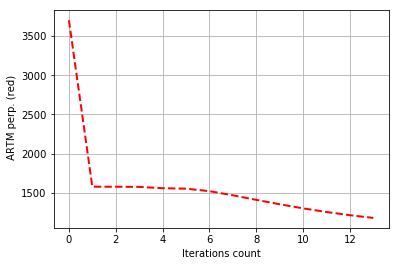

In [18]:
print_measures(model_artm)

Поскольку перплексия продолжает снижаться, попробуем еще увеличить параметры регуляризаторов.

In [19]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.888 ARTM)
Sparsity Theta: 0.131 (ARTM)
Kernel contrast: 0.338 (ARTM)
Kernel purity: 0.511 (ARTM)
Perplexity: 1020.090 (ARTM)


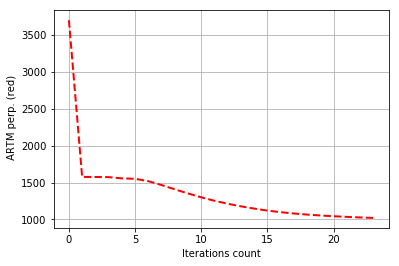

In [20]:
print_measures(model_artm)

In [21]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
лист
опубликовать
проблема
официальный_сайт
pdf
прочее
автор
кстати
стикер
недавний
---------
topic_1: 
устройство
компьютер
ноутбук
оперативный_память
кабель
usb
производитель
операционный_система
жёсткий_диск
домашний
---------
topic_2: 
курс
лицо
деталь
дело
хороший
человек
лекция
решить
стоить
фотография
---------
topic_3: 
являться
регион
оценка
процесс
результат
показатель
причина
проблема
связь
должный
---------
topic_4: 
процессор
инструкция
архитектура
память
intel
производительность
быстрый
результат
железо
современный
---------
topic_5: 
вид
набор
должный
являться
процесс
простой
вариант
разный
способ
иметь
---------
topic_6: 
пользователь
должный
необходимый
действие
любой
использование
ваш
почта
агент
правило
---------
topic_7: 
диск
сервер
виртуальный_машина
заказчик
кластер
нагрузка
хранилище
восстановление
хост
машина
---------
topic_8: 
участник
тема
доклад
конференция
перевод
рассказать
мероприятие
интересный
презентация
пройти
---------
topic_9: 
слово
част

Для 100 тем получились более хорошие темы, попробуем поменять параметры регуляризаторов.

In [22]:
model_artm_2 = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(100)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.35, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 100)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.25, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 100)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [23]:
model_artm_2.initialize(dictionary=dictionary, )

In [24]:
# добавляем метрики
model_artm_2.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm_2.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm_2.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm_2.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm_2.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

In [26]:
model_artm_2.num_document_passes = 2
model_artm_2.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 1591.231 (ARTM)


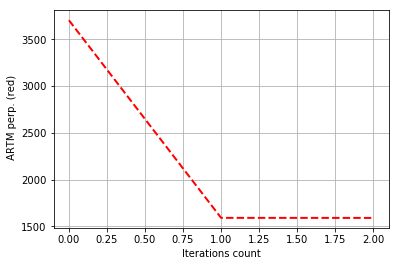

In [27]:
print_measures(model_artm_2)

In [28]:
model_artm_2.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.25, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 100)],
                                                            ))
model_artm_2.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.25, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 100)]))

In [29]:
model_artm_2.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [30]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm_2.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm_2.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm_2.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.850 ARTM)
Sparsity Theta: 0.083 (ARTM)
Kernel contrast: 0.294 (ARTM)
Kernel purity: 0.269 (ARTM)
Perplexity: 1173.495 (ARTM)


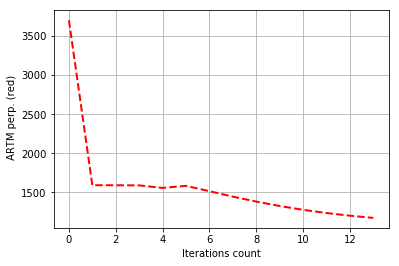

In [31]:
print_measures(model_artm_2)

In [33]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm_2.regularizers['SparsePhi'].tau
theta_tau = model_artm_2.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm_2.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm_2.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm_2.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.937 ARTM)
Sparsity Theta: 0.172 (ARTM)
Kernel contrast: 0.410 (ARTM)
Kernel purity: 0.576 (ARTM)
Perplexity: 1046.073 (ARTM)


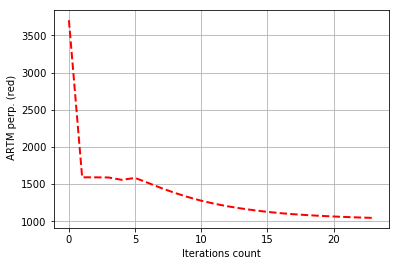

In [34]:
print_measures(model_artm_2)

In [35]:
# посмотрим на темы
for topic_name in model_artm_2.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm_2.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
красота
самый
machine_learning
высокий_вероятность
достоинство
глубоко
традиционно
отчасти
который_столкнуться
дело_обстоять
---------
topic_1: 
устройство
компьютер
ноутбук
производитель
кабель
usb
домашний
операционный_система
оперативный_память
жёсткий_диск
---------
topic_2: 
курс
деталь
дело
лицо
хороший
человек
решить
лекция
сказать
стоить
---------
topic_3: 
являться
оценка
регион
результат
процесс
показатель
причина
практика
связь
проблема
---------
topic_4: 
процессор
инструкция
архитектура
ядро
производительность
память
intel
железо
задержка
быстрый
---------
topic_5: 
вид
набор
являться
должный
простой
процесс
способ
вариант
разный
весьма
---------
topic_6: 
необходимый
действие
должный
пользователь
любой
почта
правило
ваш
использоваться
агент
---------
topic_7: 
диск
заказчик
виртуальный_машина
сервер
нагрузка
кластер
машина
восстановление
хранилище
резервный_копирование
---------
topic_8: 
участник
тема
перевод
доклад
конференция
рассказать
мероприятие
интересный

Более хорошие значения метрик (перплексия, контрастность ядра) получились для второй модели на 100 тем. 
3 удачные темы:

In [38]:
# посмотрим на темы
for topic_name in ['topic_7', 'topic_13','topic_14']:
    
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_7: 
диск
сервер
виртуальный_машина
хранилище
кластер
нагрузка
хост
восстановление
заказчик
машина
---------
topic_13: 
товар
цена
покупка
магазин
продажа
деньга
заказ
стоимость
покупатель
скидка
---------
topic_14: 
язык
код
python
язык_программирование
контекст
подход
библиотека
структура
правило
являться
---------


График обучения модели

Sparsity Phi: 0.913 ARTM)
Sparsity Theta: 0.162 (ARTM)
Kernel contrast: 0.367 (ARTM)
Kernel purity: 0.587 (ARTM)
Perplexity: 999.927 (ARTM)


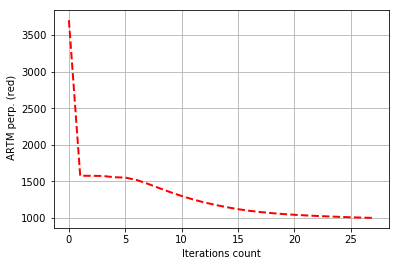

In [39]:
print_measures(model_artm)

Самая удачная модель получилась для 100 тем. Изначально использовались регуляризаторы декоррелятор матрицы Phi с параметром 0.25, сглаживание матрицы Phi (параметр 0.15). После 3 проходов добавили регуляризатор разреживания слов в темах Phi (tau = -0.15) и разреживания тем в документах Theta (tau = -0.15). Затем после одного прохода запустили 10 проходов с постепенным увеличением tau на 50% для  регуляризатора матрицы Phi и на 10% для регуляризатора матрицы Theta. Метрики модели улучшались в течении 2 итераций с увеличением значений параметров регуляризации. В результате перплексия составила 1020, контрастность ядра - 0.338, чистота ядра - 0.511.

#### Иерархическая модель 

Попробуем построить иерархическую модель. Первый уровень будет содержать 20 тем, а второй уровень - 100.

In [48]:
hierarchy = artm.hARTM()

In [49]:
level0 = hierarchy.add_level(num_topics=20)
level0.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20))
level0.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
level0.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
level0.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
level0.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.5))

In [50]:
level0.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi_1', tau=0.15))
level0.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.25))

In [51]:
level0.initialize(dictionary=dictionary)

In [52]:
level0.num_document_passes = 2
level0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.017 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 1562.921 (ARTM)


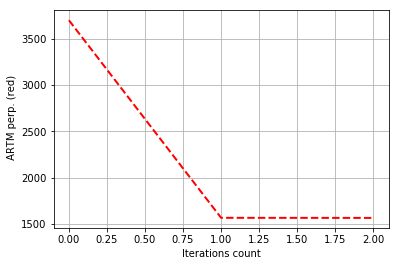

In [53]:
print_measures(level0)

In [54]:
level0.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 20)],
                                                            ))
level0.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 20)]))

In [55]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = level0.regularizers['SparsePhi'].tau
theta_tau = level0.regularizers['SparseTheta'].tau

for i in range(10):
    level0.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    level0.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    level0.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.346 ARTM)
Sparsity Theta: 0.027 (ARTM)
Kernel contrast: 0.682 (ARTM)
Kernel purity: 0.085 (ARTM)
Perplexity: 1346.656 (ARTM)


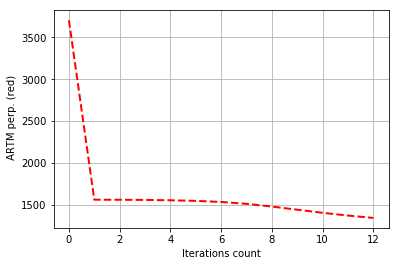

In [56]:
print_measures(level0)

In [57]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = level0.regularizers['SparsePhi'].tau
theta_tau = level0.regularizers['SparseTheta'].tau

for i in range(10):
    level0.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    level0.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    level0.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.689 ARTM)
Sparsity Theta: 0.035 (ARTM)
Kernel contrast: 0.757 (ARTM)
Kernel purity: 0.260 (ARTM)
Perplexity: 1226.221 (ARTM)


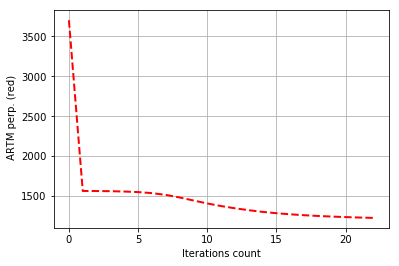

In [58]:
print_measures(level0)

In [60]:
import pandas as pd

In [61]:
parent_topic_words = pd.DataFrame({'topic': [topic_name for topic_name in level0.topic_names],
                            'words': [', '.join(level0.score_tracker['TopTokensScore'].last_tokens[topic_name]) \
                                      for topic_name in level0.topic_names]})

Темы первого уровня

In [63]:
pd.set_option('display.max_colwidth', -1)
parent_topic_words

,topic,words
0,topic_0,"использование, состояние, запись, операция, производительность, использоваться, механизм, являться, реализация, пример, изменение, позволять, случай, выполнение, необходимый, диск, отдельный, иметь, информация, реализовать"
1,topic_1,"устройство, камера, видео, смартфон, производитель, компьютер, экран, режим, android, цена, письмо, ноутбук, качество, стоить, помощь, питание, apple, телефон, рубль, проблема"
2,topic_2,"модель, материал, хороший, человек, звук, качество, дело, рука, ребёнок, деталь, стоить, самый, книга, обычный, печать, цена, свой, телефон, фотография, производство"
3,topic_3,"система, являться, связь, проблема, информация, большой, область, оператор, решение, анализ, место, определённый, процесс, причина, должный, источник, условие, наш, результат, вопрос"
4,topic_4,"наш, процессор, поскольку, существовать, скорость, происходить, ядро, энергия, пространство, результат, свет, температура, находиться, инструкция, теория, некоторый, случай, возможно, общий, обнаружить"
5,topic_5,"значение, блок, параметр, число, модуль, пример, int, простой, массив, результат, функция, вариант, вид, вывод, количество, amp, строка, наш, программа, далее"
6,topic_6,"пользователь, любой, создать, интерфейс, использоваться, использование, действие, должный, простой, доступный, необходимый, создание, позволять, случай, поддерживать, ваш, система, правило, управление, поддержка"
7,topic_7,"задача, проект, команда, клиент, тест, тестирование, сервер, процесс, ответ, заказчик, проблема, каждый, нужный, момент, случай, важный, нагрузка, количество, быстрый, должный"
8,topic_8,"писать, тема, наш, разработчик, программист, знать, вопрос, хотеть, написать, язык, участник, команда, бот, рассказать, понять, перевод, курс, клиент, проект, нужный"
9,topic_9,"элемент, программа, точка, алгоритм, объект, изображение, часть, каждый, поэтому, некоторый, размер, иметь, множество, линия, координата, находиться, разный, самый, число, символ"


In [64]:
level1 = hierarchy.add_level(num_topics=100, topic_names=['child_topic_' + str(i) for i in range(100)], 
                        parent_level_weight=1)

In [65]:
level1.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20))
level1.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
level1.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
level1.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
level1.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.5))

In [66]:
level1.regularizers.add(artm.HierarchySparsingThetaRegularizer(name="HierSp", tau=1.0))

In [67]:
level1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi_1', tau=0.15))
level1.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.25))

In [69]:
level1.initialize(dictionary=dictionary)

In [70]:
level1.num_document_passes = 2
level1.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.017 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 1971.299 (ARTM)


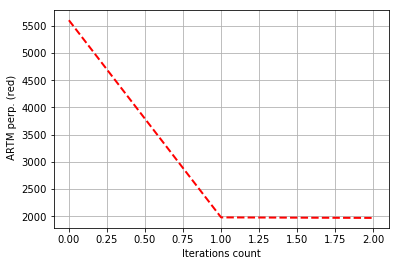

In [71]:
print_measures(level1)

In [72]:
level1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 100)],
                                                            ))
level1.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 100)]))

In [73]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = level1.regularizers['SparsePhi'].tau
theta_tau = level1.regularizers['SparseTheta'].tau

for i in range(10):
    level1.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    level1.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    level1.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.017 (ARTM)
Kernel contrast: 0.153 (ARTM)
Kernel purity: 0.064 (ARTM)
Perplexity: 1106.283 (ARTM)


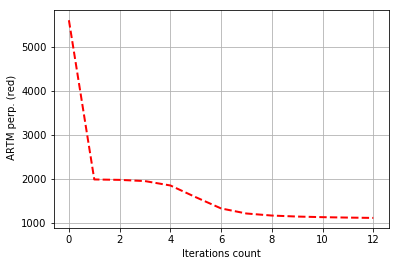

In [74]:
print_measures(level1)

In [75]:
child_topic_words = pd.DataFrame({'topic': [topic_name for topic_name in level1.topic_names],
                            'words': [', '.join(level1.score_tracker['TopTokensScore'].last_tokens[topic_name]) \
                                      for topic_name in level1.topic_names]})

Темы второго уровня

In [76]:
child_topic_words

,topic,words
0,child_topic_0,"запись, операция, производительность, состояние, использование, механизм, диск, хранилище, чтение, использоваться, выполнение, хранение, реализация, изменение, поток, оптимизация, выполняться, отдельный, реализовать, кэш"
1,child_topic_1,"устройство, камера, видео, производитель, смартфон, экран, компьютер, режим, телефон, android, ноутбук, цена, питание, датчик, apple, письмо, рубль, корпус, автомобиль, плата"
2,child_topic_2,"материал, модель, звук, ребёнок, рука, деталь, печать, фотография, производство, человек, качество, хороший, принтер, цена, телефон, книга, обычный, стоить, помещение, дело"
3,child_topic_3,"система, связь, оператор, являться, анализ, область, информация, регион, большой, источник, центр, определённый, причина, условие, оборудование, зона, проблема, учёт, закон, решение"
4,child_topic_4,"процессор, энергия, скорость, ядро, поскольку, пространство, свет, температура, существовать, земля, теория, наш, вселенная, инструкция, обнаружить, происходить, звезда, масса, находиться, расстояние"
5,child_topic_5,"значение, блок, число, параметр, модуль, int, массив, amp, вывод, цикл, простой, пример, количество, amp_amp, задать, кнопка, вид, вариант, int_int, таблица"
6,child_topic_6,"пользователь, интерфейс, любой, действие, доступный, создать, использоваться, использование, поддерживать, ваш, стандарт, создание, простой, управление, контроллер, необходимый, позволять, поддержка, правило, роль"
7,child_topic_7,"задача, проект, тест, команда, клиент, тестирование, сервер, заказчик, ответ, нагрузка, процесс, восстановление, скорость, диск, быстрый, ресурс, требование, запрос, тестировать, резервный_копия"
8,child_topic_8,"программист, писать, тема, язык, участник, бот, разработчик, написать, курс, перевод, доклад, конференция, рассказать, наш, знать, вопрос, текст, знание, понять, команда"
9,child_topic_9,"точка, элемент, алгоритм, программа, изображение, объект, размер, координата, линия, множество, часть, дерево, вектор, каждый, пиксель, символ, матрица, угол, текстура, находиться"


In [77]:
psi = level1.get_psi()

In [78]:
batch = artm.messages.Batch()
batch_name = 'phi1.batch'

with open(batch_name, "rb") as f:
    batch.ParseFromString(f.read())
    
Ntw = np.zeros(len(level0.topic_names))
    
for i,item in enumerate(batch.item):
    for (token_id, token_weight) in zip(item.field[0].token_id, item.field[0].token_weight):
        Ntw[i] += token_weight

Nt1t0 = np.array(psi) * Ntw
psi_bayes = (Nt1t0 / Nt1t0.sum(axis=1)[:, np.newaxis]).T

In [79]:
indexes_child = np.argmax(psi_bayes, axis=0)

Темы второго уровня для одной из родительских тем:

In [80]:
topic_parent_name = 'topic_5'
print(topic_parent_name + ':')
print(" ".join(level0.score_tracker['TopTokensScore'].last_tokens[topic_parent_name]))
print('')

for child in np.where(indexes_child == i)[0]:
    print('    ' + level1.topic_names[child] + ': ')
    print(" ".join(level1.score_tracker['TopTokensScore'].last_tokens[level1.topic_names[child]]))
    print('')

topic_5:
значение блок параметр число модуль пример int простой массив результат функция вариант вид вывод количество amp строка наш программа далее

    child_topic_19: 
сервер адрес пакет настройка сообщение сеть подключение домен порт конфигурация канал linux настроить драйвер протокол http хост соединение команда ядро

    child_topic_54: 
необходимый случай следующий канал информация поэтому данный проблема должный получать помощь использоваться сеть найти сообщение наш образ процесс сервер номер

    child_topic_63: 
сервер база наш команда клиент нужный проект необходимый сервис установить программа сразу приложение каждый иметь разработчик посмотреть доступ далее создание

